In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

### Read in Band10 of L2SP Product

In [2]:
base_path = '/Users/maltegenschow/Documents/Uni/SoSe23/Data Science Project/data/Landsat/LC08_L2SP_193026_20220803_20220806_02_T1/LC08_L2SP_193026_20220803_20220806_02_T1_'
LST_path = base_path + 'ST_b10.TIF'

In [3]:
with rasterio.open(LST_path) as src:
    LST = src.read(1)

### Apply Multiplicative Scale Factor and convert to celsius
_Remark: Scale factors can be read from the Landsat 8-9 Collection 2 Technical Guide:_

https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf

In [4]:
# Set all zeros to na
LST = LST.astype(float)
LST[LST == 0] = np.nan

# Apply multiplicative scale factor
LST = LST * 0.00341802
# Apply additive Offset
LST = LST + 149.0

# Convert to degrees Celsius
LST = LST - 273.15

Text(0.5, 1.0, 'Distribution of Degree Celsius Pixel Values')

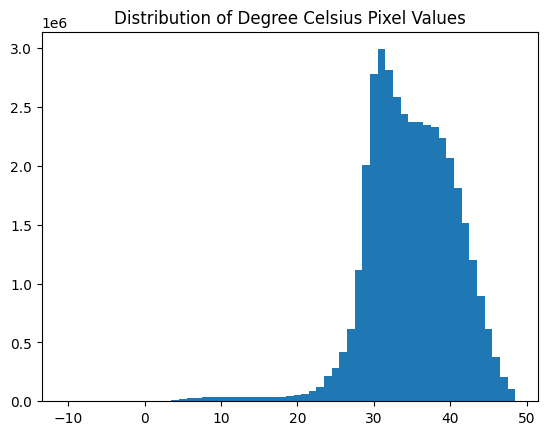

In [5]:
data = np.histogram(LST, bins=range(-10, 50, 1))
plt.bar(data[1][:-1], data[0], width=1)
plt.title('Distribution of Degree Celsius Pixel Values')

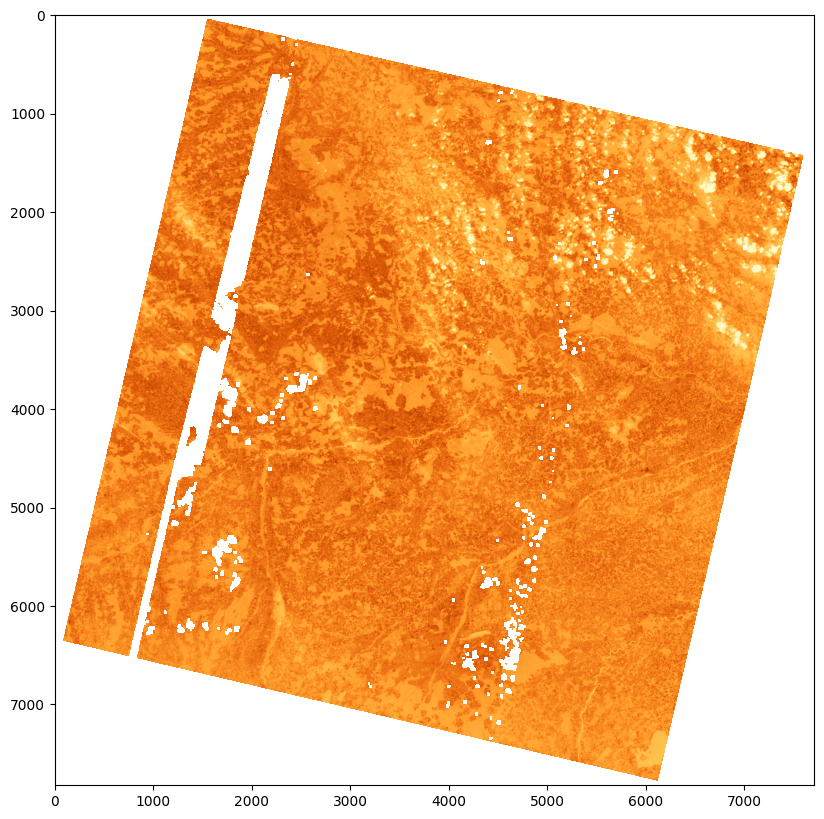

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(LST, cmap='YlOrBr')

In [7]:
#export LST image
LST_image = rasterio.open('landsat8_LST.tif','w',driver='Gtiff',
                          width=src.width, 
                          height = src.height, 
                          count=1, crs=src.crs, 
                          transform=src.transform, 
                          dtype='float64')
LST_image.write(LST,1)
LST_image.close()

### Clip Munich from Scene (and contrast with NDVI index for same area)

In [8]:
with rasterio.open('ndvi_subset.tif') as ndvi_src:
    ndvi = ndvi_src.read(1)

In [9]:
bbox_4326 = (11.576947,48.128678,11.604069,48.149555)
import rasterio.warp
[xmin, xmax], [ymin, ymax] = rasterio.warp.transform('EPSG:4326', src.crs, [bbox_4326[0], bbox_4326[2]], [bbox_4326[1], bbox_4326[3]])
bbox = (xmin, ymin, xmax, ymax)
bbox

(691743.1613381845, 5333814.307467338, 693682.4898493877, 5336202.480574397)

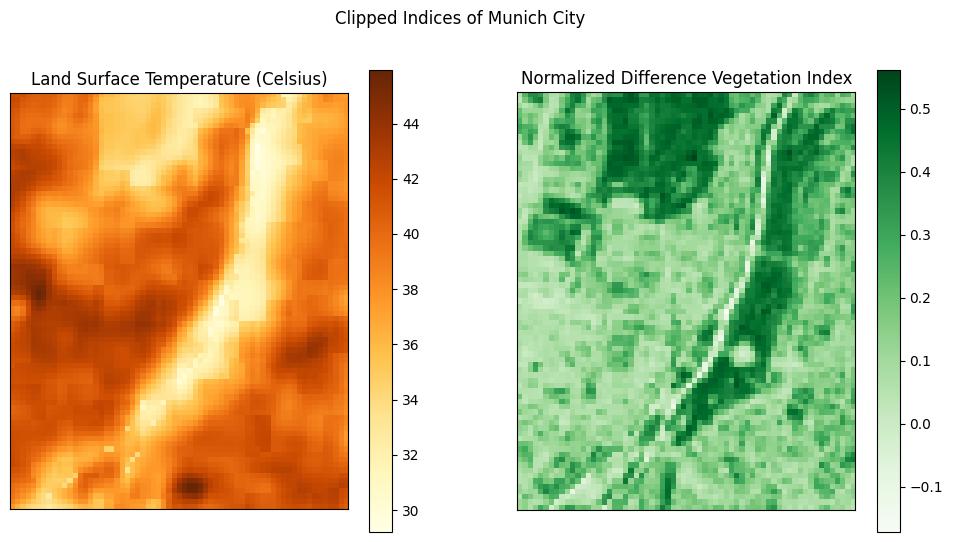

In [10]:
from rasterio.windows import from_bounds
with rasterio.open('landsat8_LST.tif') as src:
    # Get the window corresponding to the bounding box
    window = from_bounds(*bbox, src.transform)

    # Read the subset of the raster data as a numpy array
    subset = src.read(window=window)

    # Update the metadata of the new GeoTIFF to reflect the subset
    meta = src.meta
    meta.update({
        'width': window.width,
        'height': window.height,
        'transform': rasterio.windows.transform(window, src.transform)
    })

# Write the subset of the raster data to a new GeoTIFF file
#with rasterio.open('my_subset.tif', 'w', **meta) as dst:
#   dst.write(subset)
fig, ax = plt.subplots(1,2,figsize=(12, 6))
# LST Plot
lst_plot = ax[0].imshow(subset[0], cmap='YlOrBr')
plt.colorbar(lst_plot, ax = ax[0])
ax[0].set_title('Land Surface Temperature (Celsius)')
# NDVI Plot
ndvi_plot = ax[1].imshow(ndvi, cmap='Greens')
plt.colorbar(ndvi_plot, ax = ax[1])
ax[1].set_title('Normalized Difference Vegetation Index')
plt.suptitle('Clipped Indices of Munich City')
plt.setp(ax, xticks=[], yticks=[])
plt.show()